<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#User-functions" data-toc-modified-id="User-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>User functions</a></span></li><li><span><a href="#Vanilla-model-run-(original-cifar10)" data-toc-modified-id="Vanilla-model-run-(original-cifar10)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vanilla model run (original cifar10)</a></span></li><li><span><a href="#Param-search-description" data-toc-modified-id="Param-search-description-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Param search description</a></span></li><li><span><a href="#Full-Augmentation-case" data-toc-modified-id="Full-Augmentation-case-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Full Augmentation case</a></span></li><li><span><a href="#Optimizers" data-toc-modified-id="Optimizers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizers</a></span></li><li><span><a href="#Усложнение-модели.-Вариант-увеличения-нейронов" data-toc-modified-id="Усложнение-модели.-Вариант-увеличения-нейронов-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Усложнение модели. Вариант увеличения нейронов</a></span></li><li><span><a href="#Усложнение-модели.-Вариант-увеличения-глубины-сети" data-toc-modified-id="Усложнение-модели.-Вариант-увеличения-глубины-сети-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Усложнение модели. Вариант увеличения глубины сети</a></span></li><li><span><a href="#Обзор-выбранных-вариантов" data-toc-modified-id="Обзор-выбранных-вариантов-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Обзор выбранных вариантов</a></span></li><li><span><a href="#Оптимизация-наилучшей-модели" data-toc-modified-id="Оптимизация-наилучшей-модели-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Оптимизация наилучшей модели</a></span></li></ul></div>

In [120]:
# 1. Basic Imports
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import itertools
import warnings
import time
from pprint import pprint
import seaborn as sns


from tensorflow import keras as keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras import backend as K

import warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix


#from sklearn.metrics import r2_score



%matplotlib inline
warnings.filterwarnings('ignore')

#### Loading data

In [110]:
# 2. Data Loading
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [111]:
# 3. Data Preprocessing
n_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#### User functions

In [112]:
def show_pic(np_array, idx, grid=False, colorbar=False):
    shape = np_array[idx].shape
    plt.grid(grid)
    plt.imshow(np_array[idx]) #.reshape(shape)+1)/2)
    if colorbar:
        plt.colorbar()
    plt.show()

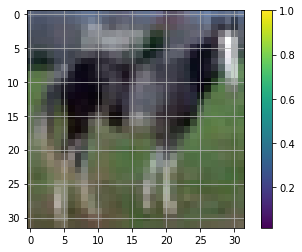

In [113]:
img_n = 37
pic = x_train[img_n]
show_pic(x_train, img_n, grid=True, colorbar=True)

In [147]:
def full_dense_classifier_compiler(layers_list, compile_params,  display_model=True):
    compile_params_keys = list(compile_params.keys())
    
    if len( set(compile_params_keys) - set(['optimizer', 'loss', 'metrics']) ) > 0:
        raise KeyError('incorrect compile params name')
    
    model = Sequential()
    
    for layer in layers_list:
        model.add(layer)
    
    optimizer = compile_params['optimizer']
    loss = compile_params['loss']
    metrics = compile_params['metrics']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if display_model:
        model.summary()

    return model

def mlp_fit_valid_cnn(model, train_images, train_labels_cat, n_classes, n_epochs=10, batch_size=32, 
                      validation_data=(x_test, y_test), verbose_mode=0, use_augmentation=False, datagen_instance=None, 
                      show_chart=True):
    
    if validation_data:
        monitor = 'val_loss'
    else:
        monitor = 'loss'
    
    es = EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=0.15*n_epochs)
    callbacks = [es]
    
    start_time = time.time()
    
    if use_augmentation and datagen_instance:
        print('fit process with augmentation started...')
        history = model.fit_generator(datagen_instance.flow(train_images, train_labels_cat, batch_size=batch_size),
                                     epochs=n_epochs, validation_data=validation_data, workers=-1, callbacks=callbacks,
                                     shuffle=True, verbose=verbose_mode)
        
    else:
        print('fit process without augmentation started...')
        history = model.fit(train_images, train_labels_cat, epochs=n_epochs, batch_size=batch_size, 
                            validation_data=validation_data, shuffle=True, verbose=verbose_mode,
                            callbacks=callbacks)
    
    if show_chart:
        fig = plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='valid')
        plt.legend()
        plt.show()
    
    best_idx = np.array(history.history['val_loss']).argmin()
    optimal_epoch_number = history.epoch[best_idx] + 1
    best_val_acc = history.history['val_accuracy'][best_idx]
    best_val_loss = history.history['val_loss'][best_idx]
    best_tr_acc = history.history['accuracy'][best_idx]
    
    
    print(f'optimal epoch number: {optimal_epoch_number}')
    print('params on optimal epoch:')
    print(f'accuracy on test: {best_val_acc:.4f}, on train: {best_tr_acc:.4f}')
    print(f'best test loss: {best_val_loss}')
          
    return model

def plot_conf_matrix(y_true, y_pred, cmap=plt.cm.Blues,  show_cbar=False, font_size=11, font_style='normal', 
                     alpha=1,linecolor='white', linewidths=0.1):

    cnf_matrix = confusion_matrix(y_true, y_pred)
    y_true_reshaped = y_true.reshape(1,-1).tolist()[0]
    xticklabels = list(set(y_true_reshaped))
    matrix = cnf_matrix[::-1]
    yticklabels = xticklabels[::-1]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()

    annot_kws = {
        'fontsize': font_size,
        'fontstyle': font_style,
        'alpha': alpha
    }

    cbar_kws = {"orientation": "vertical",
                "shrink": 1,
                'extend': 'max',
                'extendfrac': 0.01,
                "drawedges": False,
                }

    ax.set_title('Confusion Matrix')

    sns.heatmap(matrix, square=True, ax=ax, cmap=cmap, annot=True, fmt='d',
                annot_kws=annot_kws, cbar=show_cbar, cbar_kws=cbar_kws, linecolor=linecolor,
                linewidths=linewidths, xticklabels=xticklabels, yticklabels=yticklabels)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_ylim([0, len(matrix)])
    ax.set_xlabel('predicted class')
    ax.set_ylabel('true class')
    plt.show()
    
    
def mlp_predict_cnn(model, test_images, test_labels, show_metrics=True, show_conf_matrix=True):
    
    start_time = time.time()
    predict = model.predict(test_images)
    print(f'predict generated in {(time.time()-start_time):.1f} sec')
    predict = np.argmax(predict, axis=1)
        
    if show_metrics:
        print(classification_report(test_labels, predict))
    
    if show_conf_matrix:
        plot_conf_matrix(test_labels, predict)
    
    return predict

#### Vanilla model run (original cifar10)

In [115]:
# 3.1. Базовая архитектура и параметры компиляции

layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

cifar10_base_original_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                               layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                                layer_out, layer_out_f]

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': opt,
    'metrics': ['accuracy']
}

base_cifar10_model = full_dense_classifier_compiler(layers_list=cifar10_base_original_layers,
                              compile_params=comp_params)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_47 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_48 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 64)       

**Важное ограничение**  
здесь и далее в разделе поиска параметров я буду задавать жесткое ограничение на количество эпох (25), поскольку  
задача является ресурсоемкой, и поиск оптимальных параметров будет осуществляться с таким ограничением

fit process without augmentation started...


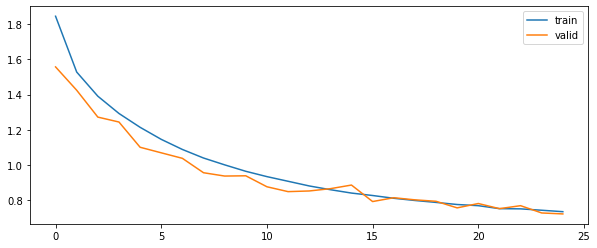

optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.7555, on train: 0.7486
best test loss: 0.7199759812355041
refit finished in 189.149873 sec
predict generated in 0.6 sec
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1000
           1       0.91      0.84      0.87      1000
           2       0.78      0.49      0.61      1000
           3       0.60      0.56      0.58      1000
           4       0.66      0.76      0.71      1000
           5       0.62      0.71      0.66      1000
           6       0.81      0.83      0.82      1000
           7       0.82      0.80      0.81      1000
           8       0.80      0.91      0.85      1000
           9       0.79      0.89      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000



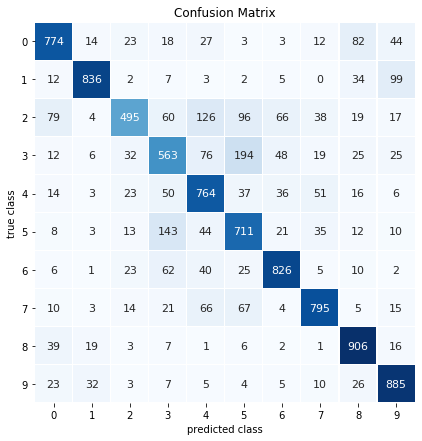

In [145]:
# 3.2. Вариант обучения без аугментации c yearly stopping callback. Валидация на тестовых данных.

layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_vanilla_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]


model_vanilla = full_dense_classifier_compiler(layers_list=model_vanilla_layers,
                              compile_params=comp_params, display_model=False)

model_vanilla = mlp_fit_valid_cnn(model=model_vanilla, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat))

predict = mlp_predict_cnn(model_vanilla, x_test, y_test, show_metrics=True, show_conf_matrix=True)

fit process with augmentation started...
  ...
    to  
  ['...']


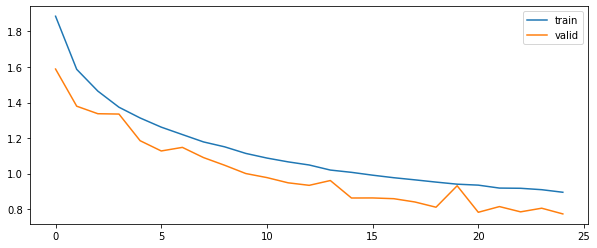

optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.7405, on train: 0.6900
best test loss: 0.7725219518661499
refit finished in 419.054280 sec
predict generated in 0.6 sec
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1000
           1       0.87      0.85      0.86      1000
           2       0.75      0.48      0.59      1000
           3       0.63      0.53      0.57      1000
           4       0.67      0.69      0.68      1000
           5       0.67      0.65      0.66      1000
           6       0.71      0.87      0.78      1000
           7       0.74      0.81      0.78      1000
           8       0.83      0.86      0.85      1000
           9       0.73      0.90      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.73     10000
weighted avg       0.74      0.74      0.73     10000



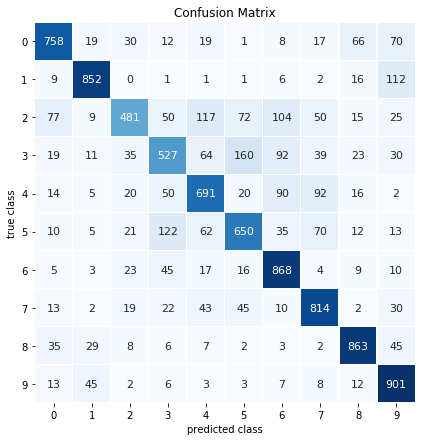

In [146]:
# 3.2. Вариант обучения без аугментации c yearly stopping callback. Валидация на тестовых данных.

layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_vanilla_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

datagen = ImageDataGenerator(
                             featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False, 
                             zca_epsilon=1e-06, 
                             rotation_range=0, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0., 
                             zoom_range=0., 
                             channel_shift_range=0.,
                             fill_mode='nearest',
                             cval=0.,
                             horizontal_flip=True,
                             vertical_flip=False,
                             rescale=None,
                             preprocessing_function=None,
                             data_format=None,
                             validation_split=0.0)


model_vanilla_aug = full_dense_classifier_compiler(layers_list=model_vanilla_layers,
                              compile_params=comp_params, display_model=False)

model_vanilla_aug = mlp_fit_valid_cnn(model=model_vanilla_aug, train_images=x_train, train_labels_cat=y_train_cat, 
                                      n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                      validation_data=(x_test, y_test_cat), use_augmentation=True, 
                                      datagen_instance=datagen)

predict = mlp_predict_cnn(model_vanilla_aug, x_test, y_test, show_metrics=True, show_conf_matrix=True)

In [150]:
# 3.3. Saving results
results = []

def add_model_results(predict, y_test=y_test, results=results, description_dict=dict()):
    description_dict['f1_macro'] = f1_score(y_test, predict, average='macro')
    description_dict['accuracy'] = accuracy_score(y_test, predict)
    results.append(description_dict)
    return results

d1 = {
    'model_name': 'cifar10_base',
    'augmentation': None,
    'activation_fx': 'relu',
    'dropout': [0.25, 0.25, 0.5],
    'padding': 'same',
    'optimizer': 'rmsprop(lr=0.0001, decay=1e-6)',
    'batch': 32,
    'n_epoch': 25}

d2 = {
    'model_name': 'cifar10_base_simple_aug',
    'augmentation': 'width_shift_range=0.1, height_shift_range=0.1, horizontal_flip',
    'activation_fx': 'relu',
    'dropout': [0.25, 0.25, 0.5],
    'padding': 'same',
    'optimizer': 'rmsprop(lr=0.0001, decay=1e-6)',
    'batch': 32,
    'n_epoch': 25}

results = add_model_results(predict, description_dict=d1)
results = add_model_results(predict2, description_dict=d2)

results

[{'model_name': 'cifar10_base',
  'augmentation': None,
  'activation_fx': 'relu',
  'dropout': [0.25, 0.25, 0.5],
  'padding': 'same',
  'optimizer': 'rmsprop(lr=0.0001, decay=1e-6)',
  'batch': 32,
  'n_epoch': 25,
  'f1_macro': 0.7349671970930771,
  'accuracy': 0.7405},
 {'model_name': 'cifar10_base_simple_aug',
  'augmentation': 'width_shift_range=0.1, height_shift_range=0.1, horizontal_flip',
  'activation_fx': 'relu',
  'dropout': [0.25, 0.25, 0.5],
  'padding': 'same',
  'optimizer': 'rmsprop(lr=0.0001, decay=1e-6)',
  'batch': 32,
  'n_epoch': 25,
  'f1_macro': 0.7541370107020042,
  'accuracy': 0.758}]

#### Param search description

Учитывая сложность исходной архитектуры и ресурсоемкость обучения, подбор гиперпараметров будет осуществляться с рядом существенных ограничений и поэтапно. Т.е. поиск по сетке будет последовательным и неполномасштабным, хотя такой принцип на гарантирует нахождение оптимума.

Этапы поиска параметров:
- (1) Аугментация vs Отсутствие аугментации
  - в данном случае будут следующие преобразования: width_shift, height_shift, zoom_range, horizontal_flip, vertical_flip, rotation
  
- (2) Подбор оптимизатора и его параметров
  - базовые параметры оптимизатора: learning rate, epsilon,
  - рассматриваемые оптимизаторы: adam, rsmprop, sgd

- (3) Увеличение ширины сети (в рамках ДЗ)

- (4) В рамках увеличения глубины сети (в рамках ДЗ)

Итоговая наилучшая модель будет дополнительно оптимизирована по:
- количеству эпох
- размеру batch size

#### Full Augmentation case

fit process with augmentation started...
  ...
    to  
  ['...']


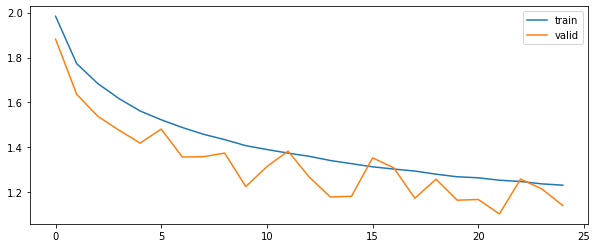

optimal epoch number: 22
params on optimal epoch:
accuracy on test: 0.6136, on train: 0.5547
best test loss: 1.1040604723930358
predict generated in 0.6 sec
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      1000
           1       0.64      0.86      0.74      1000
           2       0.62      0.38      0.47      1000
           3       0.51      0.26      0.35      1000
           4       0.61      0.42      0.50      1000
           5       0.67      0.45      0.54      1000
           6       0.48      0.88      0.62      1000
           7       0.53      0.78      0.63      1000
           8       0.77      0.63      0.70      1000
           9       0.66      0.69      0.68      1000

    accuracy                           0.60     10000
   macro avg       0.62      0.60      0.59     10000
weighted avg       0.62      0.60      0.59     10000



In [152]:
# 5.1. Model RUN

layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_aug_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                    layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                    layer_out, layer_out_f]

datagen_full = ImageDataGenerator(
                             featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False, 
                             zca_epsilon=1e-06, 
                             rotation_range=45, 
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0., 
                             zoom_range=0.10, 
                             channel_shift_range=0.,
                             fill_mode='nearest',
                             cval=0.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rescale=None,
                             preprocessing_function=None,
                             data_format=None,
                             validation_split=0.0)


model_aug = full_dense_classifier_compiler(layers_list=model_aug_layers,compile_params=comp_params, display_model=False)

model_aug = mlp_fit_valid_cnn(model=model_aug, train_images=x_train, train_labels_cat=y_train_cat, n_classes=n_classes, 
                              n_epochs=25, batch_size=32, verbose_mode=0, validation_data=(x_test, y_test_cat), 
                              use_augmentation=True, datagen_instance=datagen_full)

predict = mlp_predict_cnn(model_aug, x_test, y_test, show_metrics=True, show_conf_matrix=False)

In [153]:
# 5.2. Saving results
d3 = {
    'model_name': 'cifar10_base_full_aug',
    'augmentation': 'rotation:45, width_shift:0.05, height_shift:0.05, zoom:0.10, vert_flip, hor_flip',
    'activation_fx': 'relu',
    'dropout': [0.25, 0.25, 0.5],
    'padding': 'same',
    'optimizer': 'rmsprop(lr=0.0001, decay=1e-6)',
    'batch': 32,
    'n_epoch': 25}

results = add_model_results(predict, description_dict=d3)

Как видно, в данном случае более широкая (по сравнению с базовой) аугментация только ухудшила результаты. Возможно это связано с тем, что я ограничил кол-во эпох, однако в рамках настоящего анализа в дальнейшем я не буду использовать аугментацию. 

#### Optimizers

In [158]:
# 6.1. RMSprop grid search
lr_range = [0.01, 0.001, 0.00001]
eps_range = [1e-1, 1e-3, 1e-7]
combs = list(itertools.product(lr_range, eps_range))

for comb in combs:
    lr = comb[0]
    eps = comb[1]
    opt = RMSprop(learning_rate=lr, epsilon=eps)
    
    comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': opt,
    'metrics': ['accuracy']}
    
    print(f'lr:{lr}, epsilon:{eps}')
    
    layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
    layer_in_f = Activation('relu')
    layer_1 = Conv2D(32, (3, 3))
    layer_1_f = Activation('relu')
    layer_2 = MaxPooling2D(pool_size=(2, 2))
    layer_3 = Dropout(0.25)
    layer_4 = Conv2D(64, (3, 3), padding='same')
    layer_4_f = Activation('relu')
    layer_5 = Conv2D(64, (3, 3))
    layer_5_f = Activation('relu')
    layer_6 = MaxPooling2D(pool_size=(2, 2))
    layer_7 = Dropout(0.25)
    layer_8 = Flatten()
    layer_9 = Dense(512)
    layer_9_f = Activation('relu')
    layer_10 = Dropout(0.5)
    layer_out = Dense(n_classes)
    layer_out_f = Activation('softmax')

    model_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
              layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
              layer_out, layer_out_f]

    model_ = full_dense_classifier_compiler(layers_list=model_layers,compile_params=comp_params, display_model=False)

    model_ = mlp_fit_valid_cnn(model=model_, train_images=x_train, train_labels_cat=y_train_cat, n_classes=n_classes, 
                               n_epochs=25, batch_size=32, verbose_mode=0, validation_data=(x_test, y_test_cat), 
                               use_augmentation=False, show_chart=False)
    
    print('*'*70)

lr:0.01, epsilon:0.1
fit process without augmentation started...
Epoch 00017: early stopping
optimal epoch number: 13
params on optimal epoch:
accuracy on test: 0.7637, on train: 0.7673
best test loss: 0.68116725730896
**********************************************************************
lr:0.01, epsilon:0.001
fit process without augmentation started...
Epoch 00005: early stopping
optimal epoch number: 1
params on optimal epoch:
accuracy on test: 0.1000, on train: 0.1001
best test loss: 2.303244585800171
**********************************************************************
lr:0.01, epsilon:1e-07
fit process without augmentation started...
Epoch 00006: early stopping
optimal epoch number: 2
params on optimal epoch:
accuracy on test: 0.1000, on train: 0.0979
best test loss: 2.302989609146118
**********************************************************************
lr:0.001, epsilon:0.1
fit process without augmentation started...
optimal epoch number: 25
params on optimal epoch:
accuracy o

In [159]:
# 6.2. Adam grid search
# -- здесь я поменял пограничные значения lr и eps

lr_range = [0.001, 0.0001]
eps_range = [1e-2, 1e-3, 1e-4]
combs = list(itertools.product(lr_range, eps_range))

for comb in combs:
    lr = comb[0]
    eps = comb[1]
    opt = Adam(learning_rate=lr, epsilon=eps)
    
    comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': opt,
    'metrics': ['accuracy']}
    
    print(f'lr:{lr}, epsilon:{eps}')
    
    layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
    layer_in_f = Activation('relu')
    layer_1 = Conv2D(32, (3, 3))
    layer_1_f = Activation('relu')
    layer_2 = MaxPooling2D(pool_size=(2, 2))
    layer_3 = Dropout(0.25)
    layer_4 = Conv2D(64, (3, 3), padding='same')
    layer_4_f = Activation('relu')
    layer_5 = Conv2D(64, (3, 3))
    layer_5_f = Activation('relu')
    layer_6 = MaxPooling2D(pool_size=(2, 2))
    layer_7 = Dropout(0.25)
    layer_8 = Flatten()
    layer_9 = Dense(512)
    layer_9_f = Activation('relu')
    layer_10 = Dropout(0.5)
    layer_out = Dense(n_classes)
    layer_out_f = Activation('softmax')

    model_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
              layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
              layer_out, layer_out_f]

    model_ = full_dense_classifier_compiler(layers_list=model_layers,compile_params=comp_params, display_model=False)

    model_ = mlp_fit_valid_cnn(model=model_, train_images=x_train, train_labels_cat=y_train_cat, n_classes=n_classes, 
                              n_epochs=25, batch_size=32, verbose_mode=0, validation_data=(x_test, y_test_cat), 
                              use_augmentation=False, show_chart=False)
    
    print('*'*70)

lr:0.001, epsilon:0.01
fit process without augmentation started...
Epoch 00025: early stopping
optimal epoch number: 21
params on optimal epoch:
accuracy on test: 0.8061, on train: 0.8528
best test loss: 0.571261241865158
**********************************************************************
lr:0.001, epsilon:0.001
fit process without augmentation started...
Epoch 00017: early stopping
optimal epoch number: 13
params on optimal epoch:
accuracy on test: 0.7908, on train: 0.8141
best test loss: 0.6093568591594696
**********************************************************************
lr:0.001, epsilon:0.0001
fit process without augmentation started...
Epoch 00019: early stopping
optimal epoch number: 15
params on optimal epoch:
accuracy on test: 0.7865, on train: 0.8193
best test loss: 0.633858698272705
**********************************************************************
lr:0.0001, epsilon:0.01
fit process without augmentation started...
optimal epoch number: 25
params on optimal epoch:

In [160]:
# 6.3. SGD grid search
lr_range = [0.01, 0.001, 0.0001]
combs = list(itertools.product(lr_range, eps_range))

for lr in lr_range:
    opt = SGD(learning_rate=lr)
    
    comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': opt,
    'metrics': ['accuracy']}
    
    print(f'lr:{lr}')
    
    layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
    layer_in_f = Activation('relu')
    layer_1 = Conv2D(32, (3, 3))
    layer_1_f = Activation('relu')
    layer_2 = MaxPooling2D(pool_size=(2, 2))
    layer_3 = Dropout(0.25)
    layer_4 = Conv2D(64, (3, 3), padding='same')
    layer_4_f = Activation('relu')
    layer_5 = Conv2D(64, (3, 3))
    layer_5_f = Activation('relu')
    layer_6 = MaxPooling2D(pool_size=(2, 2))
    layer_7 = Dropout(0.25)
    layer_8 = Flatten()
    layer_9 = Dense(512)
    layer_9_f = Activation('relu')
    layer_10 = Dropout(0.5)
    layer_out = Dense(n_classes)
    layer_out_f = Activation('softmax')

    model_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
              layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
              layer_out, layer_out_f]

    model_ = full_dense_classifier_compiler(layers_list=model_layers,compile_params=comp_params, display_model=False)

    model_ = mlp_fit_valid_cnn(model=model_, train_images=x_train, train_labels_cat=y_train_cat, n_classes=n_classes, 
                              n_epochs=25, batch_size=32, verbose_mode=0, validation_data=(x_test, y_test_cat), 
                              use_augmentation=False, show_chart=False)
    
    print('*'*70)

lr:0.01
fit process without augmentation started...
optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.7633, on train: 0.7574
best test loss: 0.6706359209060669
**********************************************************************
lr:0.001
fit process without augmentation started...
optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.5000, on train: 0.4631
best test loss: 1.3882960391998291
**********************************************************************
lr:0.0001
fit process without augmentation started...
optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.2607, on train: 0.2145
best test loss: 2.0435250785827637
**********************************************************************


fit process without augmentation started...
Epoch 00022: early stopping


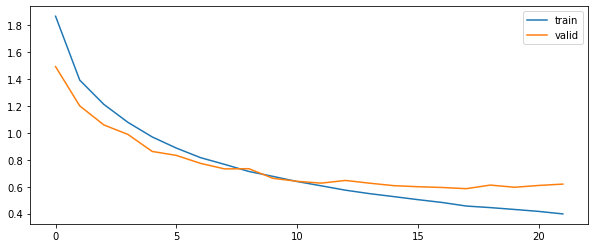

optimal epoch number: 18
params on optimal epoch:
accuracy on test: 0.8048, on train: 0.8377
best test loss: 0.5853665685653686
predict generated in 0.6 sec
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.90      0.90      0.90      1000
           2       0.78      0.69      0.73      1000
           3       0.56      0.70      0.62      1000
           4       0.78      0.78      0.78      1000
           5       0.75      0.68      0.71      1000
           6       0.89      0.80      0.84      1000
           7       0.90      0.80      0.85      1000
           8       0.81      0.92      0.86      1000
           9       0.87      0.87      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [161]:
# 6.4. Optimal Optimizer training and saving results

# RMSprop - нестабильный, а SGD - показывает плохие результаты. Выбран Adam

# Adam lr:0.001, epsilon:0.01
best_opt = Adam(learning_rate=0.001, epsilon=0.01)

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                layer_out, layer_out_f]

model_adam = full_dense_classifier_compiler(layers_list=model_layers,compile_params=comp_params, display_model=False)

model_adam = mlp_fit_valid_cnn(model=model_adam, train_images=x_train, train_labels_cat=y_train_cat, n_classes=n_classes, 
                              n_epochs=25, batch_size=32, verbose_mode=0, validation_data=(x_test, y_test_cat), 
                              use_augmentation=False, show_chart=True)

predict = mlp_predict_cnn(model_adam, x_test, y_test, show_metrics=True, show_conf_matrix=False)

d4 = {
    'model_name': 'cifar10_base_adam',
    'augmentation': None,
    'activation_fx': 'relu',
    'dropout': [0.25, 0.25, 0.5],
    'padding': 'same',
    'optimizer': 'adam(lr=0.001, epsilon=0.01)',
    'batch': 32,
    'n_epoch': 25}

results = add_model_results(predict, description_dict=d4)

#### Усложнение модели. Вариант увеличения нейронов

fit process without augmentation started...
Epoch 00018: early stopping


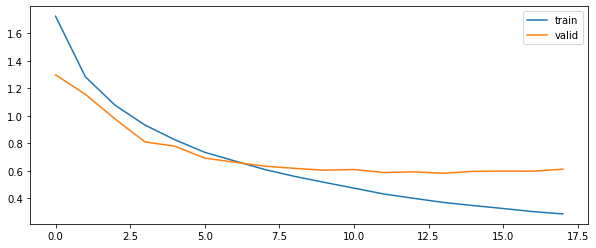

optimal epoch number: 14
params on optimal epoch:
accuracy on test: 0.8074, on train: 0.8692
best test loss: 0.5822242601156234


In [165]:
# 7.1. Пропорциональное увеличение всех нейронов в conv2d в 2 раза

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(64, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(64, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(128, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(128, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_neirons_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_neirons = full_dense_classifier_compiler(layers_list=model_neirons_layers,compile_params=comp_params, 
                                               display_model=False)

model_neirons = mlp_fit_valid_cnn(model=model_neirons, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

fit process without augmentation started...
Epoch 00012: early stopping


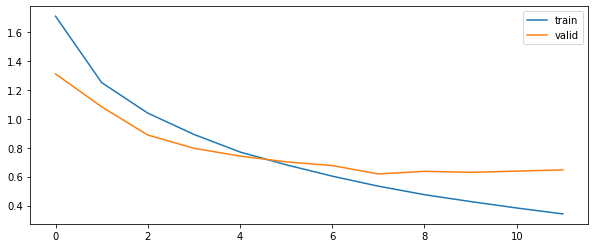

optimal epoch number: 8
params on optimal epoch:
accuracy on test: 0.7845, on train: 0.8105
best test loss: 0.6186598917484284


In [166]:
# 7.2. Постепенное интенсивное увеличение нейронов

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(64, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(128, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(256, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_neirons_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_neirons = full_dense_classifier_compiler(layers_list=model_neirons_layers,compile_params=comp_params, 
                                               display_model=False)

model_neirons = mlp_fit_valid_cnn(model=model_neirons, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

fit process without augmentation started...
Epoch 00015: early stopping


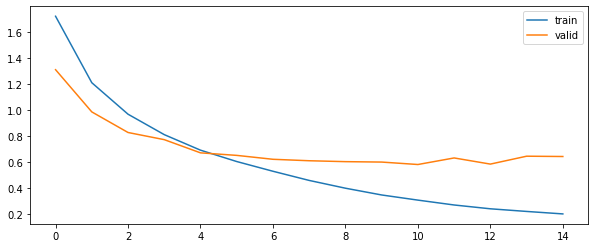

optimal epoch number: 11
params on optimal epoch:
accuracy on test: 0.8139, on train: 0.8904
best test loss: 0.5832279967546463


In [170]:
# 7.3. Постоянное большое кол-во нейронов (256)
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(256, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(256, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(256, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(256, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_neirons_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_neirons = full_dense_classifier_compiler(layers_list=model_neirons_layers,compile_params=comp_params, 
                                               display_model=False)

model_neirons = mlp_fit_valid_cnn(model=model_neirons, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

Как видно, увеличение кол-ва нейронов не привносит заметного улучшения модели.

#### Усложнение модели. Вариант увеличения глубины сети

fit process without augmentation started...


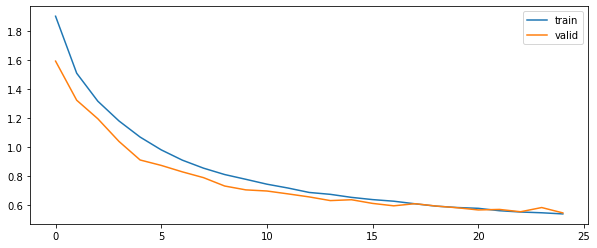

optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.8201, on train: 0.8111
best test loss: 0.5440211864948272


In [171]:
# 8.1. Добавление 1 дополнительного слоя с увеличением кол-ва нейронов (х2)
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_5_1 = Conv2D(128, (3, 3))
layer_5_1_f = Activation('relu')
layer_6_1 = MaxPooling2D(pool_size=(2, 2))
layer_7_1 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_addlayer_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, 
                        layer_5_1, layer_5_1_f, layer_6_1, layer_7_1, 
                        layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_addlayer = full_dense_classifier_compiler(layers_list=model_addlayer_layers,compile_params=comp_params, 
                                               display_model=False)

model_addlayer = mlp_fit_valid_cnn(model=model_addlayer, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

fit process without augmentation started...


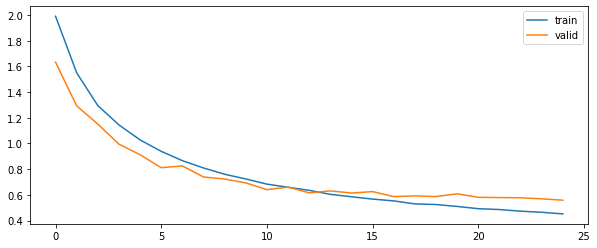

optimal epoch number: 25
params on optimal epoch:
accuracy on test: 0.8108, on train: 0.8443
best test loss: 0.5585667886257172


In [174]:
# 8.1. Добавление 1 пары дополнительных слоeв с увеличением кол-ва нейронов (х2)
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_5_1 = Conv2D(128, (3, 3))
layer_5_1_f = Activation('relu')
layer_5_2 = Conv2D(128, (3, 3))
layer_5_2_f = Activation('relu')
layer_6_2 = MaxPooling2D(pool_size=(2, 2))
layer_7_2 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_addlayer_layers2 = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, 
                        layer_5_1, layer_5_1_f, layer_5_2, layer_5_2_f, layer_6_2, layer_7_2,
                        layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_addlayer = full_dense_classifier_compiler(layers_list=model_addlayer_layers2,compile_params=comp_params, 
                                               display_model=False)

model_addlayer = mlp_fit_valid_cnn(model=model_addlayer, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=25, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

In [175]:
# updating results

predict = mlp_predict_cnn(model_addlayer, x_test, y_test, show_metrics=True, show_conf_matrix=False)

d5 = {
    'model_name': 'cifar10_2layers_added',
    'augmentation': None,
    'activation_fx': 'relu',
    'dropout': [0.25, 0.25, 0.25, 0.5],
    'padding': 'same',
    'optimizer': 'adam(lr=0.001, epsilon=0.01)',
    'batch': 32,
    'n_epoch': 25}

results = add_model_results(predict, description_dict=d5)

predict generated in 0.7 sec
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.90      0.91      0.90      1000
           2       0.83      0.66      0.74      1000
           3       0.65      0.65      0.65      1000
           4       0.80      0.77      0.79      1000
           5       0.71      0.76      0.73      1000
           6       0.83      0.88      0.85      1000
           7       0.85      0.84      0.85      1000
           8       0.87      0.88      0.88      1000
           9       0.86      0.90      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



#### Обзор выбранных вариантов

In [185]:
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(by='accuracy', ascending=False)
res_df

,model_name,augmentation,activation_fx,dropout,padding,optimizer,batch,n_epoch,f1_macro,accuracy
4,cifar10_2layers_added,None,relu,"[0.25, 0.25, 0.25, 0.5]",same,"adam(lr=0.001, epsilon=0.01)",32,25,0.809943,0.8108
3,cifar10_base_adam,None,relu,"[0.25, 0.25, 0.5]",same,"adam(lr=0.001, epsilon=0.01)",32,25,0.799039,0.7977
1,cifar10_base_simple_aug,"width_shift_range=0.1, height_shift_range=0.1,...",relu,"[0.25, 0.25, 0.5]",same,"rmsprop(lr=0.0001, decay=1e-6)",32,25,0.754137,0.7580
0,cifar10_base,None,relu,"[0.25, 0.25, 0.5]",same,"rmsprop(lr=0.0001, decay=1e-6)",32,25,0.734967,0.7405
2,cifar10_base_full_aug,"rotation:45, width_shift:0.05, height_shift:0....",relu,"[0.25, 0.25, 0.5]",same,"rmsprop(lr=0.0001, decay=1e-6)",32,25,0.587262,0.6017


Как видно из результатов выше, за счет применения оптимизатора Adam и добавления глубины сети удалось увеличить метрику с 0,74 (base model) до 0,81.

#### Оптимизация наилучшей модели

fit process without augmentation started...
Epoch 00054: early stopping


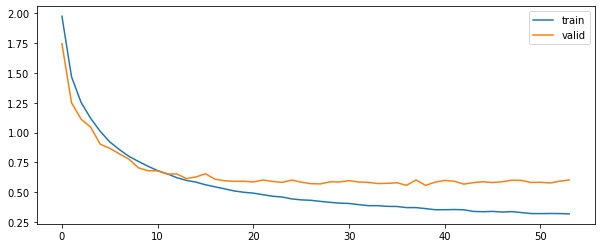

optimal epoch number: 39
params on optimal epoch:
accuracy on test: 0.8192, on train: 0.8735
best test loss: 0.5571443884372711


In [186]:
# 10.1. Прогон модели на большом количестве эпох
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': best_opt,
    'metrics': ['accuracy']}
    
layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_5_1 = Conv2D(128, (3, 3))
layer_5_1_f = Activation('relu')
layer_5_2 = Conv2D(128, (3, 3))
layer_5_2_f = Activation('relu')
layer_6_2 = MaxPooling2D(pool_size=(2, 2))
layer_7_2 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_addlayer_layers2 = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, 
                        layer_5_1, layer_5_1_f, layer_5_2, layer_5_2_f, layer_6_2, layer_7_2,
                        layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_addlayer = full_dense_classifier_compiler(layers_list=model_addlayer_layers2,compile_params=comp_params, 
                                               display_model=False)

model_addlayer = mlp_fit_valid_cnn(model=model_addlayer, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=100, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

In [188]:
# 10.2. Подбор batch size c кол-вом эпох = 55 (исходя из прошлого оптимального значения = 39)
batch_list = [16, 32, 48, 64]

for b in batch_list:
    print(f'batch size = {b}')
    print('-'*70)
    comp_params = {
        'loss': 'categorical_crossentropy',
        'optimizer': best_opt,
        'metrics': ['accuracy']}

    layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
    layer_in_f = Activation('relu')
    layer_1 = Conv2D(32, (3, 3))
    layer_1_f = Activation('relu')
    layer_2 = MaxPooling2D(pool_size=(2, 2))
    layer_3 = Dropout(0.25)
    layer_4 = Conv2D(64, (3, 3), padding='same')
    layer_4_f = Activation('relu')
    layer_5 = Conv2D(64, (3, 3))
    layer_5_f = Activation('relu')
    layer_6 = MaxPooling2D(pool_size=(2, 2))
    layer_7 = Dropout(0.25)
    layer_5_1 = Conv2D(128, (3, 3))
    layer_5_1_f = Activation('relu')
    layer_5_2 = Conv2D(128, (3, 3))
    layer_5_2_f = Activation('relu')
    layer_6_2 = MaxPooling2D(pool_size=(2, 2))
    layer_7_2 = Dropout(0.25)
    layer_8 = Flatten()
    layer_9 = Dense(512)
    layer_9_f = Activation('relu')
    layer_10 = Dropout(0.5)
    layer_out = Dense(n_classes)
    layer_out_f = Activation('softmax')

    model_addlayer_layers2 = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                            layer_5, layer_5_f, layer_6, layer_7, 
                            layer_5_1, layer_5_1_f, layer_5_2, layer_5_2_f, layer_6_2, layer_7_2,
                            layer_8, layer_9, layer_9_f, layer_10, 
                            layer_out, layer_out_f]

    model_addlayer = full_dense_classifier_compiler(layers_list=model_addlayer_layers2,compile_params=comp_params, 
                                                   display_model=False)

    model_addlayer = mlp_fit_valid_cnn(model=model_addlayer, train_images=x_train, train_labels_cat=y_train_cat, 
                                      n_classes=n_classes, n_epochs=55, batch_size=b, verbose_mode=0, 
                                      validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=False)
    print('*'*70)

batch size = 16
----------------------------------------------------------------------
fit process without augmentation started...
Epoch 00031: early stopping
optimal epoch number: 22
params on optimal epoch:
accuracy on test: 0.8027, on train: 0.8199
best test loss: 0.5866846747040748
**********************************************************************
batch size = 32
----------------------------------------------------------------------
fit process without augmentation started...
Epoch 00042: early stopping
optimal epoch number: 33
params on optimal epoch:
accuracy on test: 0.8157, on train: 0.8597
best test loss: 0.553335294675827
**********************************************************************
batch size = 48
----------------------------------------------------------------------
fit process without augmentation started...
Epoch 00036: early stopping
optimal epoch number: 27
params on optimal epoch:
accuracy on test: 0.8151, on train: 0.8406
best test loss: 0.571120131921768

Оптимальный размер batch = 32

fit process without augmentation started...
Epoch 00039: early stopping


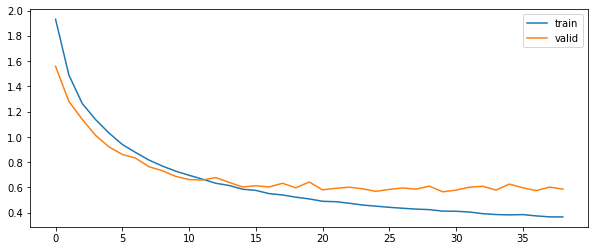

optimal epoch number: 30
params on optimal epoch:
accuracy on test: 0.8141, on train: 0.8561
best test loss: 0.565765739941597
predict generated in 0.7 sec
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.89      0.93      0.91      1000
           2       0.77      0.70      0.74      1000
           3       0.66      0.65      0.65      1000
           4       0.78      0.82      0.80      1000
           5       0.75      0.72      0.73      1000
           6       0.80      0.90      0.84      1000
           7       0.86      0.85      0.85      1000
           8       0.91      0.86      0.88      1000
           9       0.92      0.84      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



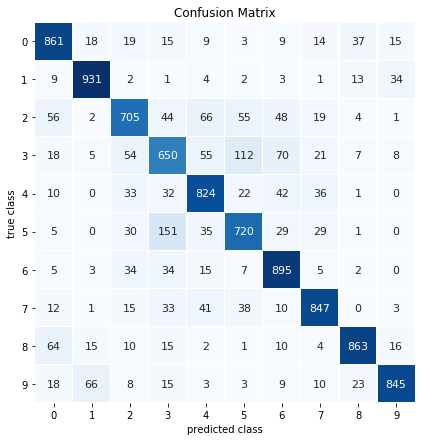

In [191]:
# 10.3. Финальное обучение модели и вывод прогноза

layer_in = Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:])
layer_in_f = Activation('relu')
layer_1 = Conv2D(32, (3, 3))
layer_1_f = Activation('relu')
layer_2 = MaxPooling2D(pool_size=(2, 2))
layer_3 = Dropout(0.25)
layer_4 = Conv2D(64, (3, 3), padding='same')
layer_4_f = Activation('relu')
layer_5 = Conv2D(64, (3, 3))
layer_5_f = Activation('relu')
layer_6 = MaxPooling2D(pool_size=(2, 2))
layer_7 = Dropout(0.25)
layer_5_1 = Conv2D(128, (3, 3))
layer_5_1_f = Activation('relu')
layer_5_2 = Conv2D(128, (3, 3))
layer_5_2_f = Activation('relu')
layer_6_2 = MaxPooling2D(pool_size=(2, 2))
layer_7_2 = Dropout(0.25)
layer_8 = Flatten()
layer_9 = Dense(512)
layer_9_f = Activation('relu')
layer_10 = Dropout(0.5)
layer_out = Dense(n_classes)
layer_out_f = Activation('softmax')

model_final_layers = [layer_in, layer_in_f, layer_1, layer_1_f, layer_2, layer_3, layer_4, layer_4_f,
                        layer_5, layer_5_f, layer_6, layer_7, 
                        layer_5_1, layer_5_1_f, layer_5_2, layer_5_2_f, layer_6_2, layer_7_2,
                        layer_8, layer_9, layer_9_f, layer_10, 
                        layer_out, layer_out_f]

model_final = full_dense_classifier_compiler(layers_list=model_final_layers,compile_params=comp_params, 
                                               display_model=False)

model_final = mlp_fit_valid_cnn(model=model_final, train_images=x_train, train_labels_cat=y_train_cat, 
                                  n_classes=n_classes, n_epochs=55, batch_size=32, verbose_mode=0, 
                                  validation_data=(x_test, y_test_cat), use_augmentation=False, show_chart=True)

final_predict = mlp_predict_cnn(model_final, x_test, y_test, show_metrics=True, show_conf_matrix=True)

In [201]:
# 10.4. Итоговая архитектура модели
model_final.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_283 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_408 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_284 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_409 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_209 (Dropout)        (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_285 (Conv2D)          (None, 15, 15, 64)      